## Train modified LeNet CNN on CIFAR-10

We train a CNN with two conv layers, two max-pooling layers and three fully-connected layers on the CIFAR-10 dataset. 


### Settings

In [4]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import json
from vis_utils import *
from model_def import *
from model_train import *


# specify experiment settings
expName = 'cifar-lenet-v1_w1-100'   #change conv1 dim
w1 = 100 # change conv1 dim
w2 = 50

batchSize = 100
useGpu = True
numEpochs = 30
learningRate = 0.01
gamma = 0.1  # learning rate decay
lr_decay_step = 10 # decay lr every "x" epochs
momentum = 0.9
weight_decay = 5e-3

# -----------------------------------------------------------------------------


# experiment folder
expDir = os.path.join('./data', expName)

# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data(batchSize)

Files already downloaded and verified
Files already downloaded and verified


### Network training

Trains a CNN on CIFAR-10 and saves it by default under "./data/cifar-lenet-v1_w1-500" as 'net-trained.dat'. If the pre-trained network is available, it should be saved here to be automatically loaded instead of training from scratch.

In [5]:
# create experiment folder
if not os.path.exists(expDir):
    os.makedirs(expDir)
    
# save training config 
# (NOTE: changing values in the JSON will not reflect in training)
cfg = {'useGpu': useGpu, 'numEpochs': numEpochs, \
       'learningRate': learningRate, \
       'batchSize': batchSize, 'momentum': momentum, \
       'weight_decay': weight_decay, \
       'gamma': gamma, 'w1': w1, 'w2': w2}

# cfg = json.load(file(os.path.join(expDir,'train_config.json'), 'r'))
with open(os.path.join(expDir,'train_config.json'), 'w') as config_file :
    json.dump(cfg, config_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

# create ConvNet
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
print(net)

# Define a Loss function and optimizer settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learningRate, \
                      momentum=momentum, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, lr_decay_step, gamma=gamma)

if not os.path.isfile(os.path.join(expDir, 'net-trained.dat')):
    # Train the network
    train_cifar_net(net, trainloader, testloader, \
                    criterion, (optimizer,lr_scheduler), expDir, \
                    batchSize=batchSize,
                    numEpochs=numEpochs, useGpu=useGpu, \
                    doVisFilter=False, \
                    fixFilterList=[], verboseFrequency=100)

    torch.save(net.state_dict(), os.path.join(expDir,'net-trained.dat'))
else:
    print 'Loading network state dict from file.'
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    print 'Done.'

NetWide (
  (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(100, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (1250 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)
Loading network state dict from file.
Done.


### Eval trained network

The network accuracy on train and test sets is saved in a JSON file in the experiment folder.

In [26]:
# Evaluate
if useGpu:
    net.cuda()

train_acc = accuracy_on_dataset(net, trainloader, useGpu)
print('Accuracy of the network on the 50000 training images: %d %%' % (
    train_acc))

test_acc = accuracy_on_dataset(net, testloader, useGpu)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    test_acc))

res = {'train_acc': train_acc, 'test_acc': test_acc}

# cfg = json.load(file(os.path.join(expDir,'train_config.json'), 'r'))
with open(os.path.join(expDir,'model_acc.json'), 'w') as res_file :
    json.dump(res, res_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

Accuracy of the network on the 50000 training images: 85 %
Accuracy of the network on the 10000 test images: 76 %


### Filter visualizations

The first layer filter similarity matrix and filter visualization figures are saved under the experiment folder.

KeyboardInterrupt: 

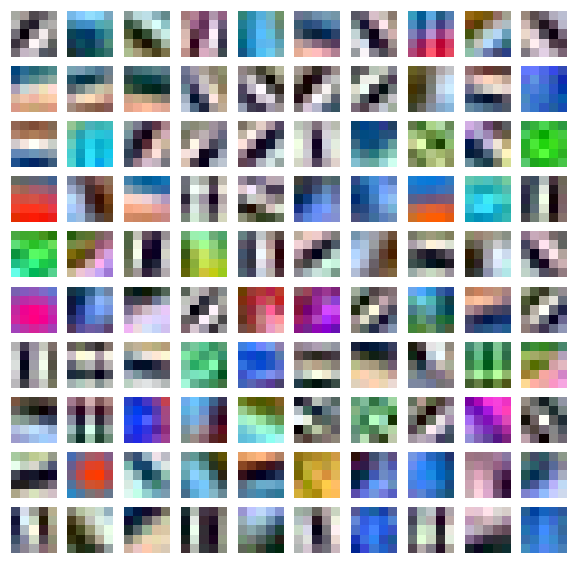

In [27]:
net.cpu()
similMat, w = get_layer_cosine_similarity(net, 'conv1.weight') # returned as numpy arrays
np.save(os.path.join(expDir,'simil-mat'), similMat)
np.save(os.path.join(expDir,'w-mat'), w)
smat = np.load(os.path.join(expDir,'simil-mat.npy'))
w_mat = np.load(os.path.join(expDir,'w-mat.npy'))

f = plt.figure()
plt.imshow(similMat)
plt.colorbar()
f.savefig(os.path.join(expDir,'lenet-simil-mat.png'), 
                        bbox_inches='tight')

# Visualize first layer filters
%matplotlib inline
param_dict = net.state_dict()
w_conv1 = param_dict['conv1.weight']
w_conv1 = w_conv1.numpy()
f = vis_kernels(w_conv1, num_cols=10) # input must be a Kx3xWxH tensor.
f.savefig(os.path.join(expDir,'lenet-filter.png'), 
                        bbox_inches='tight')

## Reduce Duplicate Filters

In [41]:
# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
print net

NetWide (
  (conv1): Conv2d(3, 500, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(500, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (1250 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [29]:
net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)

Original network data loss: 0.6871


In [47]:
# Settings
%matplotlib inline
SIMIL_THRESH = 0.8
LAYER_CURR = 'conv1'
LAYER_NEXT = 'conv2'

### Connected components on filter similarity graph

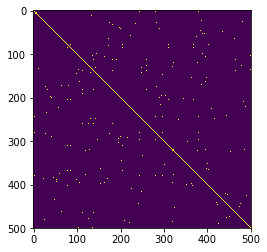

In [48]:
# Get an adjancency matrix by thresholding the similarity matrix
net.cpu()
similMat, _ = get_layer_cosine_similarity(net, LAYER_CURR+'.weight') # returned as numpy arrays
sz = similMat.shape
adj_mat = np.greater(similMat, SIMIL_THRESH)
plt.imshow(adj_mat)  # show adjacency matrix


In [49]:
# Find connected components in the graph induced by the adjacency matrix
cc_list, n_comps = get_adjmat_conn_comp(adj_mat)
print 'Number of connected comps in graph: %d ' % n_comps


Number of connected comps in graph: 239 


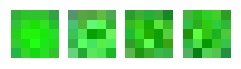

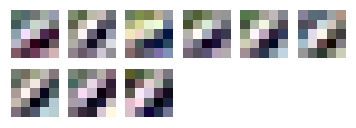

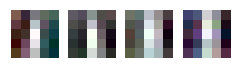

In [50]:
# Some sanity-checks: visualize some of the filter groups

net.cpu()
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
layer_curr_biases = get_param(net, LAYER_CURR+'.bias')
layer_next_weights = get_param(net, LAYER_NEXT+'.weight')

f = vis_kernels(layer_curr_weights.numpy()[cc_list[2]]) 
f = vis_kernels(layer_curr_weights.numpy()[cc_list[3]]) 
f = vis_kernels(layer_curr_weights.numpy()[cc_list[5]])

In [51]:
# [OPTIONAL] 
# Plot the filters in each filter group and save the figures to file
outDir = os.path.join(expDir, ('filter_ccomp_%.2f' % SIMIL_THRESH))
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
for i in range(len(cc_list)):
        
    f = vis_kernels(layer_curr_weights.numpy()[cc_list[i]]) 
     
    f.savefig(os.path.join(outDir, ('%d.png' % i)), \
             bbox_inches='tight')
    plt.close(f)
    
plt.rcParams.update(plt.rcParamsDefault)

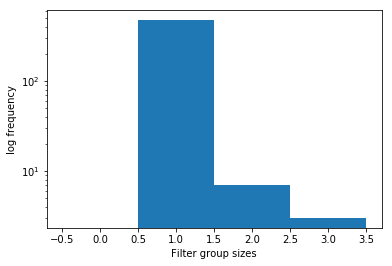

In [11]:
# Distribution of filter-cc sizes
cc_sizes = [len(x) for x in cc_list]
f = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
plt.hist(cc_sizes, bins=range(np.max(cc_sizes)+1), align='left', log=True);
# plt.xticks(range(np.max(cc_sizes)));
plt.xlabel('Filter group sizes'); plt.ylabel('log frequency')
f.savefig(os.path.join(expDir, 'filter-group-size-hist_%.2f.png' % SIMIL_THRESH), \
          bbox_inches='tight')

### Network reduction

Reducing a network by eliminating near-duplicate filters consists of the following steps, after having formed groups of similar filters:

1. down-scale the filters of the current layer to have unit norm, and correspondingly up-scale the next layer filters.
2. collapse filter groups

In [12]:
# Check the network accuracy pre-reduction
net.eval()
net.cuda()
orig_accu = accuracy_on_dataset(net, testloader, True)
print 'Network accuracy: %.2f%%' % orig_accu

net.cuda()
new_data_loss = get_dataset_loss(net, testloader)
orig_data_loss = np.asarray(orig_data_loss)
print 'Orig mean data loss: %f' % np.mean(orig_data_loss)

Network accuracy: 76.00%
Orig mean data loss: 0.677848


### Scale filters

In [13]:
# scale filters
net.cpu()
scale_net_params(net, LAYER_CURR, LAYER_NEXT)


In [14]:
# Sanity-checks: norms should be near 1
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
print torch.norm(layer_curr_weights[0],p=2)
print torch.norm(layer_curr_weights[1],p=2)


0.999999991712
1.00000001202


### Reduce similar filters


In [15]:

reduce_similar_filters(net, LAYER_CURR, LAYER_NEXT, SIMIL_THRESH)

In [16]:
# Sanity check: verify that the network's param sizes have changed
print net.conv1.weight.size()
print net.conv1.bias.size()
print net.conv2.weight.size()

torch.Size([485, 3, 5, 5])
torch.Size([485])
torch.Size([50, 485, 5, 5])


In [17]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu

res = {'orig_accu': orig_accu, 'reduced_accu': abl_accu, \
       'num_filters': n_comps}
with open(os.path.join(expDir,'reduce_dup_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
    json.dump(res, res_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

Reduced network accuracy: 76.00 %


In [18]:
# save reduced network 
torch.save(net.state_dict(), os.path.join(expDir,'net-reduced-dup-%.2f.dat' % SIMIL_THRESH))

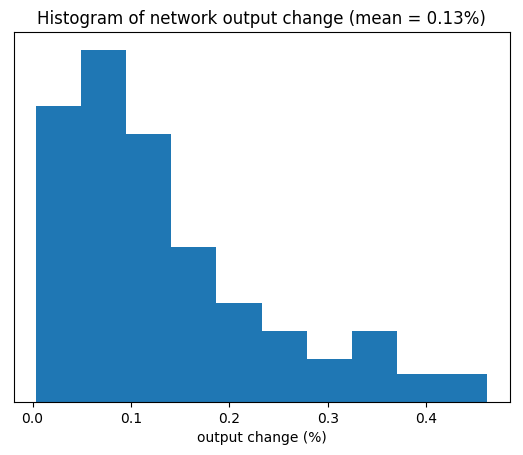

In [19]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
f.savefig(os.path.join(expDir,'loss-delta-reduced-dup-%.2f.png' % SIMIL_THRESH))

### Baseline: low L1 norm

In [20]:
# baseline: keep same number of filters as the duplicate method
NUM_KEEP = n_comps 

# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)


Original network data loss: 0.6778


In [21]:

reduce_low_norm_filters(net, LAYER_CURR, LAYER_NEXT, NUM_KEEP)

In [22]:
# Evaluate baseline network's accuracy
net.cuda()
net.eval()
baseline_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % baseline_accu

res = {'orig_accu': orig_accu, 'reduced_accu': baseline_accu, \
        'num_filters': n_comps}
with open(os.path.join(expDir,'reduce_norm_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
    json.dump(res, res_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

Reduced network accuracy: 76.00 %


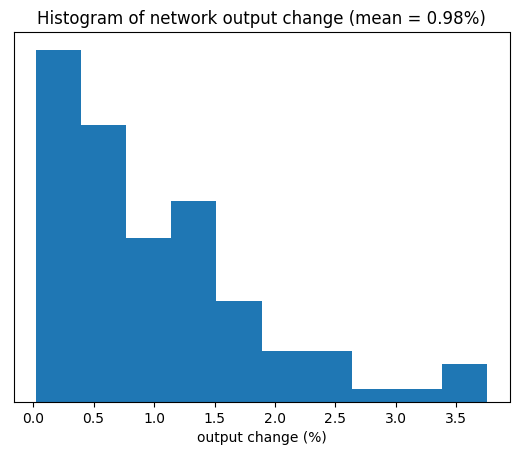

In [23]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
f.savefig(os.path.join(expDir,'loss-delta-reduced-norm-%.2f.png' % SIMIL_THRESH))

## Data Loss plots

The accuracy on a dataset is too discretized to truly measure the fluctuations due to small perturbations in the weights. A more sensitive measure is the variation in the data loss term, which is the actual output of the network.

In [3]:
outDir = 'data/figures/cnn-cifar'
if not os.path.exists(outDir):
    os.makedirs(outDir)


def plot_loss_fig(compression, acc_dup, acc_norm, num_filter):
    f = plt.figure()
    plt.plot(compression, acc_dup, 'o-', label='dup')
    plt.plot(compression, acc_norm, 'o-', label='norm')
    plt.xlabel('Compression (%)')
    plt.xticks(compression)
    plt.ylabel('Mean data loss change (%)')
    plt.title('fc1: %d' % num_filter)
    plt.legend(loc="upper left")
    return f

In [ ]:
# w1: 50
num_w1 = 50.0
thresh = [1, 0.9, 0.85, 0.8]
loss_dup = [0, ]
loss_norm = [0, ]
num_filters = [50, 50, 49, 48]
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

f = plot_loss_fig(compression, loss_dup, loss_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-50-data-loss.png'), \
          bbox_inches='tight')


In [ ]:
# w1: 100
num_w1 = 100.0
thresh = [1, 0.9, 0.85, 0.8]
loss_dup = [0, ]
loss_norm = [0, ]
num_filters = [100, 98, 86, 81]
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

f = plot_loss_fig(compression, loss_dup, loss_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-100-data-loss.png'), \
          bbox_inches='tight')


In [ ]:
# w1: 500
num_w1 = 500.0
thresh = [1, 0.9, 0.85, 0.8]
loss_dup = [0, ]
loss_norm = [0, ]
num_filters = [500, 425, 339, 239]
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

f = plot_loss_fig(compression, loss_dup, loss_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-500-data-loss.png'), \
          bbox_inches='tight')


In [ ]:
# w1: 1000
num_w1 = 1000.0
thresh = [1, 0.9, 0.85, 0.8]
loss_dup = [0, ]
loss_norm = [0, ]
num_filters = np.asarray([1000, 858, 647, 441])
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

f = plot_acc_fig(compression, loss_dup, loss_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-1000-data-loss.png'), \
          bbox_inches='tight')

